# What's wrong with Patient X's Desmoid Tumor? (1/4)

## Introduction 

Patient X discovered a lump on her back and after completing a biopsy diagnosed her with a Desmoid Tumor on her back - The tumor was surgically removed then and remained dormant now.

The tumor returned aggressively. To date there has been no definitive genetic test confirming the genetic makeup of a Desmoid Tumor, <b>that means no Beta-catenin or APC mutations are found</b>, despite it looking and behaving like a Desmoid.

Additional "Fish Test” was conducted in the hope of identifying a specific EGFR inhibitor however nothing was detected by the test.

Tumor is microsatellite stable with only 1 mutation, 9 copy number alterations. No structural variants are detected.

## Approach

Since the usual tests came back with negative result, I would try to extend the search by looking at journal entries that document desmoid cancer and see if other potential pathway(s) would enable the development of it.

Therefore, I start with a desktop research to see if any historical reference that I can use.

## 1. Desktop study using PubMed abstracts

I extract topic(s) or keyword(s) from journal entries to narrow down the search space in connection to Desmoid Cancer. I primarily used PubMed abstracts as the starting point.

I am using Biopython to extract those abstracts with keyword "desmoid".  The helper function is as follows.

In [ ]:
from Bio import Entrez
def pubmed_ids(key):
    """ extract PMID number from Pub Med """
    handle = Entrez.esearch(db="pubmed", term=key, retmax=40000000)
    record = Entrez.read(handle)
    ids = list(record['IdList'])
    return ids

In [ ]:
# import libraries
import pandas as pd
from tqdm import tqdm
from collections import deque, OrderedDict
import time
import gensim
from gensim.corpora import Dictionary
import spacy
import scispacy
import nltk
from nltk import ngrams, FreqDist
from corextopic import corextopic as ct
from negspacy.negation import Negex
import numpy as np
from scipy.spatial.distance import cosine

Then I use SciSpacy model to clean up the text and extract entity for topic modeling

In [3]:
%%time
nlp_craft = spacy.load('en_ner_craft_md')
nlp_bionlp = spacy.load('en_ner_bionlp13cg_md')

CPU times: user 10.3 s, sys: 687 ms, total: 11 s
Wall time: 11 s


In [6]:
# Since abstract usually contains a bunch of words/phrases that are
# non-informative to the analysis.  The following list contains
# those words/phrases to remove before further analysis
word_to_remove = ['- ','ABSTRACT:','BACKGROUND ','CASE: ',
                  'CASE PRESENTATION:','CASE REPORT ',
                  'CASE SUMMARY:','CLINICAL QUESTION/LEVEL OF EVIDENCE: ',
                  'CONCLUSIONS:','CONCLUSIONS.-: ','CONCLUSIONS: - ','Conclusion: ',
                  'Conclusions: ','CONCLUSION:','DATA SOURCES.-: ','DATA SOURCES: - ',
                  'DIAGNOSES: ','DIAGNOSES AND OUTCOMES: ','DISCUSSION:',
                  'INTERPRETATION:','INTERVENTIONS: ','FUNDING: ','LESSONS: ',
                  'MATERIALS AND METHODS: ','METHODS:','METHODS: ','Methods:',
                  'METHOD:','OBJECTIVES:','OBJECTIVE:','OBJECTIVE AND METHOD:',
                  'OBJECTIVE.-: ','OBJECTIVE: - ','OUTCOMES: ','PATIENT CONCERNS: ',
                  'PRESENTATION OF CASE: ','RESULTS:','RESULT:',
                  'MATERIALS AND METHODS:', '(',')','MEDLINE', 'FINDINGS']

In [7]:
%%time
t = deque()
for i in range(len(df)):
    text = df.loc[i,'text']
    for word in word_to_remove:
        text = text.replace(word,'') # clean up the abstracts by removing non-informative words/phrases
    if len(text.split(' '))>40: # I also remove the abstract that is too short to be useful
        t.append(text)
print (len(t))

2482
CPU times: user 101 ms, sys: 4.73 ms, total: 106 ms
Wall time: 105 ms


In [8]:
# Helper functions to preprocess the text to increase the signal-to-noise ratio
def extract_specific_tokens(nlp, paragraph): # using English common POS as starting point
    POS_to_remove = ['ADP','ADV','AUX',
                     'CONJ','SCONJ','SPACE',
                     'DET','INTJ','NUM','PRON',
                     'CCONJ','PUNCT','SYM',
                     'X','VERB','PART'] # extract nouns (and some adjectives) to enhance the information content
    doc = nlp(paragraph)
    pr = []
    for token in doc:
        if token.pos_ not in POS_to_remove:
            if '%' not in token.text:
                pr.append(token.text)
            else:
                pass
    return pr

def extract_keyword(text):
    start_pos = text.find('"')
    if text[start_pos+1:-2]=='':
        pass
    else:
        return text[start_pos+1:-1]

## 2. Topic Modeling 

### 2.1 Latent Dirichlet Allocation

After extracting a set of potentially informative abstracts, I am using two different NER models, namely <b>'craft'</b> and <b>'bionlp13cg'</b>, to extract genes and/or gene products [1]

The two models cover slightly different domains so I hope it will complement each other and cast a wider net to extract entity of interest.

In [9]:
%%time
nlp_eng = spacy.load('en_core_web_lg')
nlps = [nlp_craft, nlp_bionlp]
nlps_names  = ['nlp_craft', 'nlp_bionlp']
label_to_remove = ['DISEASE','CANCER','MULTI_TISSUE_STRUCTURE','PATHOLOGICAL_FORMATION','ORGAN','TISSUE','ORGANISM_SUBDIVISION','CL','CELL_TYPE','CELL','SO','GO','CELLULAR_COMPONENT','ORGANISM_SUBSTANCE','TAXON','ORGANISM']

# Process to extract entities for topic analysis
doc_list = []
for paragraph in tqdm(t): 
    text = ' '.join(extract_specific_tokens(nlp_eng, paragraph)) # remove common words
    doc_list.append(text)

new_doc = []
for paragraph in tqdm(doc_list): 
    for nlp in nlps: # use different biomedical domain corpus to enrich the document informative content
        doc = nlp(paragraph)
        pr = [ent.text for ent in doc.ents if ent.label_ not in label_to_remove] # extract biomedical domain relevant entity
        new_doc.append(pr)

len(new_doc) # print out the total number of documents in the corpus

100%|██████████| 2482/2482 [01:05<00:00, 37.68it/s]

CPU times: user 1min 58s, sys: 1.17 s, total: 1min 59s
Wall time: 1min 59s


4964

In [10]:
# I turn the corpus extracted above into format ready for gensim to generate topics
word = Dictionary(new_doc)
corpus = [word.doc2bow(doc) for doc in new_doc]

In [11]:
# the parameters I used to extract topics
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=word,
                                           num_topics=10, 
                                           random_state=42,
                                           update_every=1,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 42 s, sys: 38.4 ms, total: 42.1 s
Wall time: 42.1 s


In [13]:
# Below are 10 topics with keywords identified from PubMed abstracts
# I limit myself to 10 topics because I want high quality output and 
# don't want to be overwhelmed by keywords that are probably irrelevant.

for topic in lda_model.print_topics(num_words=20):
    print (topic)
    print ()

(0, '0.054*"protein" + 0.028*"electron" + 0.025*"APC gene" + 0.024*"APC mutations" + 0.022*"vimentin" + 0.020*"FDG" + 0.017*"APC mutation" + 0.015*"BCL-6" + 0.014*"p53" + 0.012*"ER" + 0.012*"indomethacin" + 0.012*"polyposis coli APC gene" + 0.011*"Ewing" + 0.011*"PDGF" + 0.010*"Rb" + 0.010*"molecular" + 0.008*"IOERT" + 0.008*"vincristine" + 0.008*"vinblastine methotrexate" + 0.007*"pigmented"')

(1, '0.035*"ALK" + 0.021*"GS" + 0.017*"CD34" + 0.016*"proteins" + 0.013*"VEGF" + 0.012*"IMP3" + 0.012*"LEF1" + 0.011*"radiotherapy" + 0.011*"telomerase" + 0.010*"Radiotherapy" + 0.009*"tyrosine kinase inhibitors" + 0.009*"USP6" + 0.008*"ALK1 p80" + 0.008*"protein" + 0.007*"compounds" + 0.007*"drug" + 0.007*"EWS" + 0.007*"testololactone" + 0.007*"trans" + 0.007*"estrogens"')

(2, '0.106*"doxorubicin" + 0.047*"drug" + 0.034*"TNF" + 0.033*"progesterone" + 0.019*"NTRK3" + 0.017*"STAT6" + 0.016*"chemotherapy" + 0.009*"ascorbic acid" + 0.008*"nonsteroidal" + 0.008*"TFE3" + 0.008*"melphalan" + 0.008*"

In [14]:
%%time
# Extract keywords for further analysis from topics
keyword_lst = []
for topic in tqdm(lda_model.print_topics(num_words=20)):
    index, formula = topic
    components = formula.split(" + ")
    for component in components:
        keyword = extract_keyword(component)
        keyword_lst.append(keyword)
len(list(set(keyword_lst)))

100%|██████████| 10/10 [00:00<00:00, 42755.39it/s]

CPU times: user 2.92 ms, sys: 1.35 ms, total: 4.28 ms
Wall time: 3.12 ms


188

In [21]:
list(set(keyword_lst))

['Clinoril',
 'molecular',
 'FAP',
 'TGFbeta1',
 'BMP',
 'MMP-9',
 'flaps',
 'imatinib',
 'desmin',
 'Ewing',
 'protein',
 'Ga-67 citrate',
 'vimentin',
 'intravenous',
 'citrate',
 'FAP DT',
 'estrogen',
 'Doxorubicin',
 'IOERT',
 'MMPs',
 'cyclic',
 'IHC beta catenin',
 'NTRK3',
 'hyaline',
 'progesterone',
 'p16INK4a',
 'TFE3',
 'FAP patients',
 'EWS',
 'alphaE catenin',
 'ascorbic acid',
 'melphalan',
 'estrogen progesterone receptors',
 'pigmented',
 'estrogen receptor',
 'CSF1',
 'hemoglobin',
 'MYH',
 'SAMD9',
 'goserelin acetate',
 'colchicine',
 'PARP-1',
 'APC gene mutation',
 'ALK',
 'beta catenin protein',
 'PDGF',
 'compounds',
 'sorafenib',
 'Adriamycin',
 'Rhamm',
 'TNF - alpha',
 'beta Catenin',
 'KIT PDGFRA',
 'APC',
 'WT1 cytoplasmic',
 'cyclin D1',
 'estrogens',
 'vinblastine',
 'PCNA',
 'Nuclear beta catenin',
 'hormones',
 'CTNNB1',
 'methotrexate',
 'GS',
 'TNF',
 'L1',
 'tyrosine kinase inhibitors',
 'meloxicam',
 'intraperitoneal',
 '4.1B',
 'TRK',
 'Wnt',
 'fib

In [38]:
# Extract gene-liked items
genes = [key for key in list(set(keyword_lst)) if (len(key)>2 and len(key)<8)]

In [39]:
len(genes), genes

(73,
 ['FAP',
  'BMP',
  'MMP-9',
  'flaps',
  'desmin',
  'Ewing',
  'protein',
  'citrate',
  'FAP DT',
  'IOERT',
  'MMPs',
  'cyclic',
  'NTRK3',
  'hyaline',
  'TFE3',
  'EWS',
  'CSF1',
  'MYH',
  'SAMD9',
  'PARP-1',
  'ALK',
  'PDGF',
  'Rhamm',
  'APC',
  'PCNA',
  'CTNNB1',
  'TNF',
  '4.1B',
  'TRK',
  'Wnt',
  'NSAIDs',
  'Radical',
  'USP6',
  'COX-2',
  'CDT',
  'STAT6',
  'Ki-67',
  'PDGFRA',
  'VBL MTX',
  'NOTCH3',
  'SIRT1',
  'ROR2',
  'CD117',
  'BCL-6',
  'MTX',
  'p16',
  'FOXM1',
  'p53',
  'WT1',
  'bcl-2',
  'actin',
  'mRNA',
  'pigment',
  'Notch',
  'LEF1',
  'M CSF',
  'BMPs',
  'midkine',
  'MMP',
  'radical',
  'PKC',
  'drug',
  'FDG',
  'acid',
  'ICI',
  'CD34',
  'KIT',
  'S45F',
  'trans',
  'Apc',
  'VEGF',
  'IMP3',
  'ERbeta'])

In [40]:
# remove those non-gene like keys
genes.remove('FAP')
genes.remove('desmin')
genes.remove('flaps')
genes.remove('protein')
genes.remove('citrate')
genes.remove('FAP DT')
genes.remove('cyclic')
genes.remove('hyaline')
genes.remove('4.1B')
genes.remove('Radical')
genes.remove('radical')
genes.remove('pigment')
genes.remove('M CSF')
genes.remove('drug')
genes.remove('acid')
genes.remove('midkine')
genes.remove('VBL MTX')

In [43]:
len(genes), genes

(56,
 ['BMP',
  'MMP-9',
  'Ewing',
  'IOERT',
  'MMPs',
  'NTRK3',
  'TFE3',
  'EWS',
  'CSF1',
  'MYH',
  'SAMD9',
  'PARP-1',
  'ALK',
  'PDGF',
  'Rhamm',
  'APC',
  'PCNA',
  'CTNNB1',
  'TNF',
  'TRK',
  'Wnt',
  'NSAIDs',
  'USP6',
  'COX-2',
  'CDT',
  'STAT6',
  'Ki-67',
  'PDGFRA',
  'NOTCH3',
  'SIRT1',
  'ROR2',
  'CD117',
  'BCL-6',
  'MTX',
  'p16',
  'FOXM1',
  'p53',
  'WT1',
  'bcl-2',
  'actin',
  'mRNA',
  'Notch',
  'LEF1',
  'BMPs',
  'MMP',
  'PKC',
  'FDG',
  'ICI',
  'CD34',
  'KIT',
  'S45F',
  'trans',
  'Apc',
  'VEGF',
  'IMP3',
  'ERbeta'])

### 2.2 Negative Matrix Factorization

In addition to the LDA, I also use NMF to see if it will uncover keywords that are missing in LDA.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

cv = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy)

In [14]:
tf = cv.fit_transform(new_doc)

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10,random_state=1,alpha=.1,l1_ratio=.5).fit(tf)

In [31]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

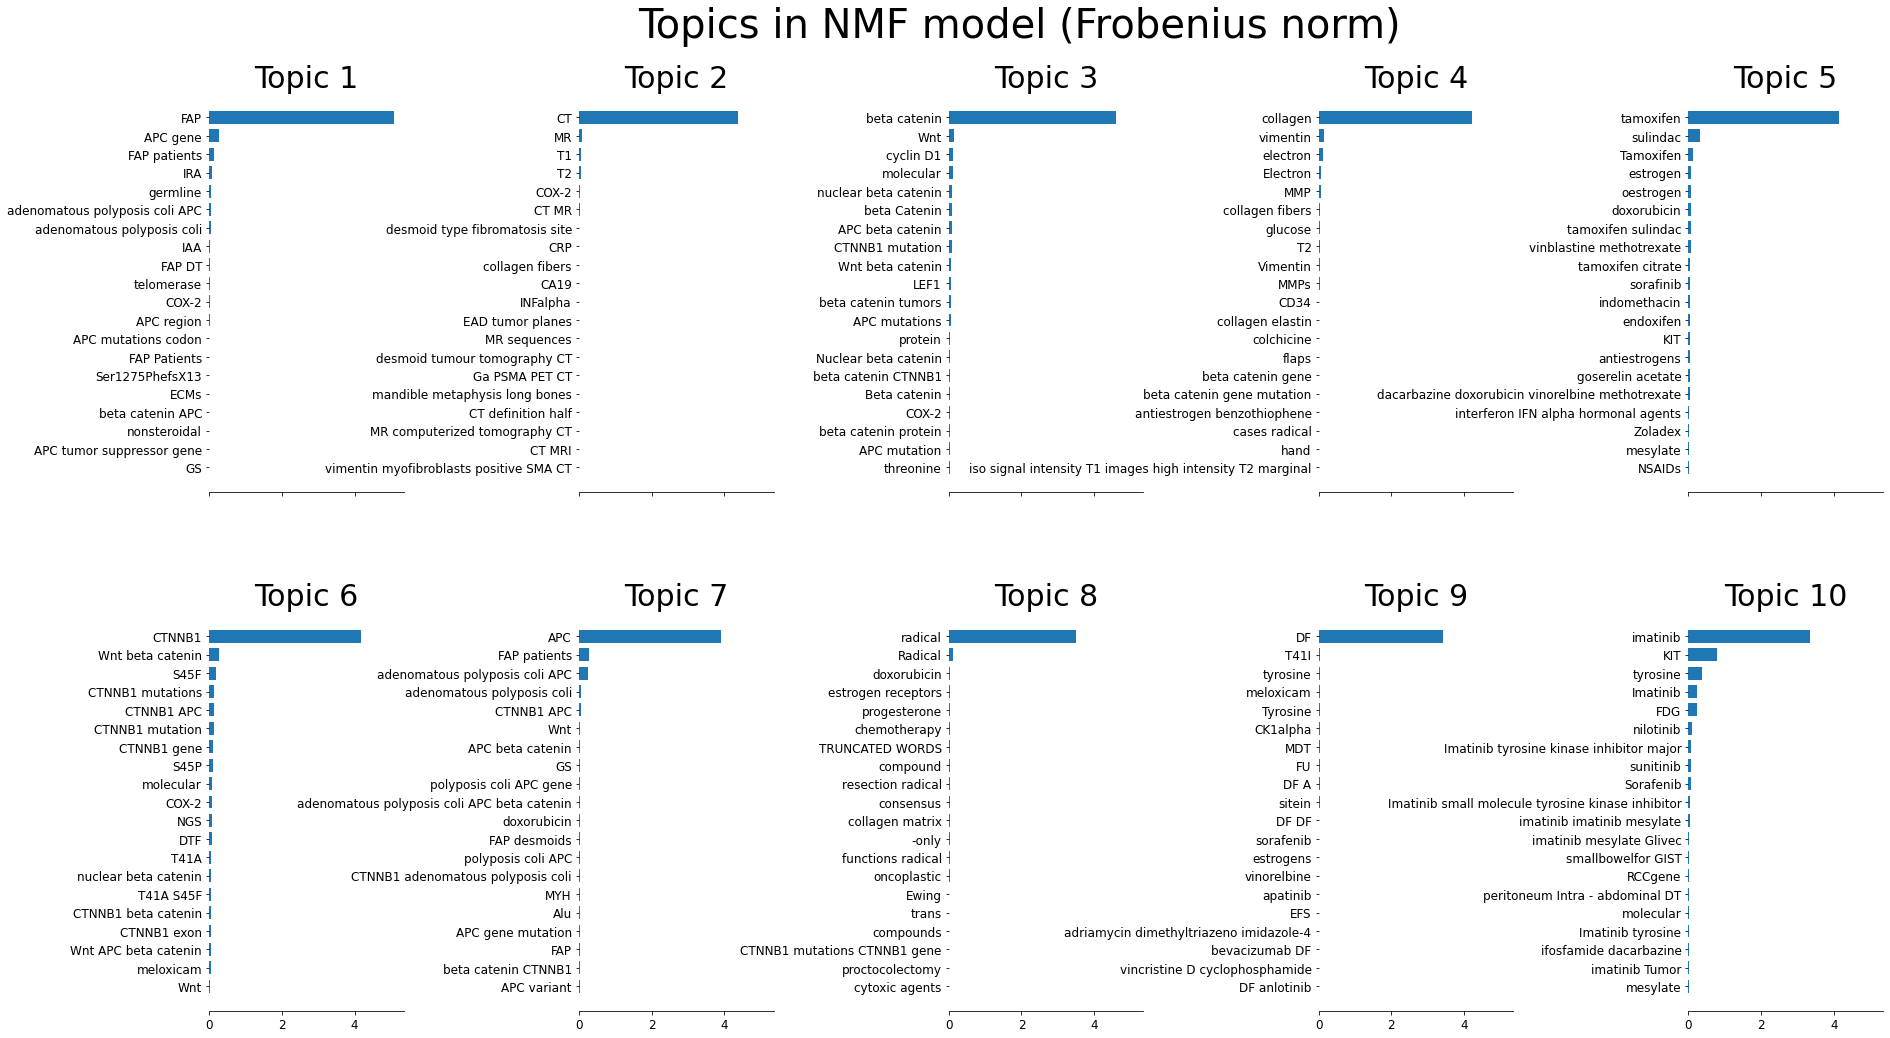

In [34]:
tfidf_feature_names = cv.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 20,'Topics in NMF model (Frobenius norm)')

<b>Additional input from NMR:</b>
- Indole-3-acetic acid (IAA): Indole-3-acetic acid (IAA) has recently shown anticancer activity in combination with horseradish peroxidase. The current study demonstrated that IAA irradiated with ultraviolet B (IAA(UVB)) is able to generate free radicals and induce cell death in a time-dependent fashion in PC-3 prostate cancer cells, while PC-3 cells treated with IAA alone exhibited no toxic responses. It was also found through Western blot analysis that the cytotoxic effect of IAA(UVB) resulted from apoptosis.

- C-reactive protein (CRP): C-reactive protein (CRP) is a predominant protein of the acute phase response; its blood levels have long been used as a minimally invasive index of any ongoing inflammatory response, including that occurring in cancer.

- CD34

- LEF1: LEF1 knockdown experiments in cell lines reveal that depending on the cellular context, LEF1 can induce pro-apoptotic signals. LEF1 can also suppress proliferation, migration and invasiveness of Rhabdomyosarcoma (RMS) cells both in vitro and in vivo. Furthermore, LEF1 can induce myodifferentiation of the tumor cells. This may involve regulation of other LEF1/TCF factors i.e. TCF1, whereas β-catenin activity plays a subordinate role. Together these data suggest that LEF1 rather has tumor suppressive functions and attenuates aggressiveness in a subset of RMS

- S45P

- T41A, T41I

- NGF: Nerve Growth Factor (NGF) research has shown that this factor acts not only outside its classical domain of the peripheral and central nervous system, but also on non-neuronal and cancer cells. This latter observation has led to divergent hypothesis about the role of NGF, its specific distribution pattern within the tissues and its implication in induction as well as progression of carcinogenesis.  Studies indicate that the only presence of NGF is unable to generate cell carcinogenesis, both in normal neuronal and non-neuronal cells/tissues. However, it cannot be excluded the possibility that the co-expression of NGF and pro-carcinogenic molecules might open to different consequence. Whether NGF plays a direct or an indirect role in cell proliferation during carcinogenesis remains to demonstrate.

- MYH: MUTYH-associated polyposis (also known as MYH-associated polyposis) is an autosomal recessive polyposis syndrome. The disorder is caused by mutations in both alleles (genetic copies) of the DNA repair gene, MUTYH. The MUTYH gene encodes a base excision repair protein, which corrects oxidative damage to DNA.

- Alu: a RNA sequence that induces epithelial-to-mesenchymal transition (EMT) by acting as a molecular sponge of oncogene miR-566.  In normal cells, unmethylated Alu elements tend to locate in the vicinity of functionally rich regions and display epigenetic features consistent with a direct impact on genome regulation. In cancer cells, Alu repeats are more resistant to hypomethylation than other retroelements. Genome segmentation based on high/low rates of Alu hypomethylation allows the identification of genomic compartments with differential genetic, epigenetic, and transcriptomic features. Alu hypomethylated regions show low transcriptional activity, late DNA replication, and its extent is associated with higher chromosomal instability.

- Casein kinase 1 alpha (CK1α), encoded by CSNK1A1 in humans, is a member of the CK1 family of proteins that has broad serine/threonine protein kinase activity and is one of the main components of the Wnt/β-catenin signaling pathway. 

### Reference 

[1] https://allenai.github.io/scispacy/